<a href="https://colab.research.google.com/github/Yangxin666/Graph_Autoencoder_Based_Imputation_Summary/blob/main/GNN_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Graph Autoencoder for PV Timeseries Data Imputation

---


An application of two spatiotemporal forecasting algorithms:
*   **GCN: A Temporal Graph Convolutional Network for Traffic Prediction** 
*   **GCRN: Structured Sequence Modeling with Graph Convolutional Recurrent Networks**

---


  T-GCN combines with the graph convolutional network (GCN) and gated recurrent unit (GRU). Specifically, the GCN is used to learn complex topological structures to capture spatial dependence and the gated recurrent unit is used to learn dynamic changes of traffic data to capture temporal dependence.

  GCRN blends ChebConv Graph Convolutions to identify spatial structures with RNNs (Ex: LSTM, GRU, etc) to find dynamic temporal patterns.

1.   GCN: https://ieeexplore.ieee.org/document/8809901
2.   GCRN: https://link.springer.com/chapter/10.1007/978-3-030-04167-0_33

Model 1:
**Encoder (GCRN: Graph CNN + GRU) + Decoder (FFNN)**



# Denoising Graph Autoencoder for Imputation
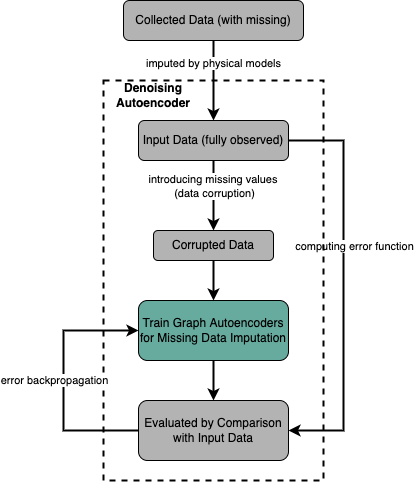



#Set Up

In [2]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install torch-geometric-temporal

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 7.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 32.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.5 MB 31.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 750 kB 6.8 MB/s 
     |████████████████████████████████| 407 kB 25.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=1b226f4ed3748edb653da3fdf51772318a35e566c5e01c5e3a722308ffe40ecd
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     |████████████████████████████████| 46 kB 3.7 MB/s 
  Created wheel for torch-geometric-tempo

## Part 1: Data Downloading and Preprocessing

60% Training, 20% Validation, 20% Testinng

In [12]:
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset(lags=14)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

train_dataset, valid_dataset = temporal_signal_split(train_dataset, train_ratio=0.75)

In [33]:
mask = torch.FloatTensor(1068, 14).uniform_() > 0.2
mask.shape

torch.Size([1068, 14])

In [38]:
mask.int()

tensor([[ True,  True, False,  ...,  True, False,  True],
        [ True,  True,  True,  ..., False,  True, False],
        [ True, False,  True,  ...,  True,  True,  True],
        ...,
        [ True, False,  True,  ...,  True,  True,  True],
        [ True, False, False,  ...,  True,  True,  True],
        [ True, False,  True,  ..., False, False, False]])

# Part 2: Different Architectures of Autoencoders

In [36]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.nn.attention import TemporalConv
from torch_geometric_temporal.nn.recurrent import TGCN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 14)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

class StandardGCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(StandardGCN, self).__init__()
        self.st = TemporalConv(in_channels, out_channels, kernel_size)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.st(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h


class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

class GCNEncoder(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GCNEncoder, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(out_channels, 2)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

class GCNDecoder(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GCNDecoder, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(out_channels, 14)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

class RecurrentGCNAE(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCNAE, self).__init__()
        self.recurrent_encode = GConvGRU(node_features, filters, 2)
        self.recurrent_decode = GConvGRU(filters, 14, 2)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent_encode(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.recurrent_decode(h, edge_index, edge_weight)
        return h

class TGCNAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TGCNAE, self).__init__()
        self.encode = TGCN(in_channels, out_channels)
        self.decode = TGCN(out_channels, in_channels)

    def forward(self, x, edge_index, edge_weight):
        h = self.encode(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.decode(h, edge_index, edge_weight)
        return h

In [ ]:
from tqdm import tqdm

Encode = GCNEncoder(node_features=14, filters=8)
Decode = GCNEncoder(node_features=14, filters=12)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

from tqdm import tqdm

model = StandardGCN(in_channels=14, out_channels=8, kernel_size = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

#Part 3: Model Training

In [60]:
from tqdm import tqdm

model = RecurrentGCNAE(node_features=14, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.x)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [44:15<00:00, 53.12s/it]


In [40]:
from tqdm import tqdm
import numpy as np
#model = TGCNAE(in_channels=14, out_channels=4)
model = RecurrentGCN(node_features=14, filters=32)
min_valid_loss = np.inf
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in tqdm(range(50)):
    train_loss = 0.0
    for time, snapshot in enumerate(train_dataset):
        mask = torch.FloatTensor(1068, 14).uniform_() > 0.2
        corrupted_x = torch.mul(snapshot.x, mask.int())
        y_hat = model(corrupted_x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_hat-snapshot.x)**2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Calculate Loss
        train_loss += loss.item()
        
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for time, snapshot in enumerate(valid_dataset):
        mask = torch.FloatTensor(1068, 14).uniform_() > 0.2
        corrupted_x = torch.mul(snapshot.x, mask.int())
        y_hat = model(corrupted_x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_hat-snapshot.x)**2)
        # Calculate Loss
        valid_loss += loss.item()
 
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss/429} \t\t Validation Loss: {valid_loss/122}')
    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss
         
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

  2%|▏         | 1/50 [00:39<32:34, 39.89s/it]

Epoch 50 		 Training Loss: 0.32708558330794313 		 Validation Loss: 0.27715406426396527


  4%|▍         | 2/50 [01:18<31:22, 39.22s/it]

Epoch 50 		 Training Loss: 0.23790844724381163 		 Validation Loss: 0.23697493017696944


  6%|▌         | 3/50 [01:57<30:34, 39.03s/it]

Epoch 50 		 Training Loss: 0.21178572732599188 		 Validation Loss: 0.21752159291359244


  8%|▊         | 4/50 [02:36<29:57, 39.08s/it]

Epoch 50 		 Training Loss: 0.20431553211176035 		 Validation Loss: 0.21296452498826823


 10%|█         | 5/50 [03:16<29:25, 39.24s/it]

Epoch 50 		 Training Loss: 0.19596969249434681 		 Validation Loss: 0.20666436270856467


 12%|█▏        | 6/50 [03:55<28:55, 39.45s/it]

Epoch 50 		 Training Loss: 0.19708234858471196 		 Validation Loss: 0.2073809533822732


 14%|█▍        | 7/50 [04:35<28:10, 39.32s/it]

Epoch 50 		 Training Loss: 0.18787893885638052 		 Validation Loss: 0.19794217106260237


 16%|█▌        | 8/50 [05:14<27:27, 39.23s/it]

Epoch 50 		 Training Loss: 0.18638585844795744 		 Validation Loss: 0.19909658661631288


 18%|█▊        | 9/50 [05:53<26:48, 39.23s/it]

Epoch 50 		 Training Loss: 0.18181504479377142 		 Validation Loss: 0.19431942542556857


 20%|██        | 10/50 [06:32<26:07, 39.20s/it]

Epoch 50 		 Training Loss: 0.18276152271768709 		 Validation Loss: 0.19513641267282064


 22%|██▏       | 11/50 [07:11<25:29, 39.21s/it]

Epoch 50 		 Training Loss: 0.18709956680908627 		 Validation Loss: 0.19747452975296584


 24%|██▍       | 12/50 [07:50<24:47, 39.14s/it]

Epoch 50 		 Training Loss: 0.18356035102705856 		 Validation Loss: 0.19378030697097542


 26%|██▌       | 13/50 [08:29<24:04, 39.05s/it]

Epoch 50 		 Training Loss: 0.17553962850487315 		 Validation Loss: 0.1878103516140922


 28%|██▊       | 14/50 [09:08<23:29, 39.16s/it]

Epoch 50 		 Training Loss: 0.18038264003805904 		 Validation Loss: 0.19387212615521227


 30%|███       | 15/50 [09:48<22:50, 39.17s/it]

Epoch 50 		 Training Loss: 0.17561503240973245 		 Validation Loss: 0.191160041777814


 32%|███▏      | 16/50 [10:27<22:11, 39.16s/it]

Epoch 50 		 Training Loss: 0.17665632819379126 		 Validation Loss: 0.19277511616466475


 34%|███▍      | 17/50 [11:06<21:31, 39.14s/it]

Epoch 50 		 Training Loss: 0.18019561690119876 		 Validation Loss: 0.19242451749131328


 36%|███▌      | 18/50 [11:45<20:52, 39.15s/it]

Epoch 50 		 Training Loss: 0.17017917666749244 		 Validation Loss: 0.18692606699759842


 38%|███▊      | 19/50 [12:24<20:15, 39.20s/it]

Epoch 50 		 Training Loss: 0.1903418783263449 		 Validation Loss: 0.19931029442880974


 40%|████      | 20/50 [13:04<19:37, 39.25s/it]

Epoch 50 		 Training Loss: 0.17688708307790313 		 Validation Loss: 0.19579004923828314


 42%|████▏     | 21/50 [13:43<18:58, 39.25s/it]

Epoch 50 		 Training Loss: 0.17484337108813244 		 Validation Loss: 0.1882614944069112


 44%|████▍     | 22/50 [14:22<18:18, 39.25s/it]

Epoch 50 		 Training Loss: 0.1725096239041893 		 Validation Loss: 0.1882286038799364


 46%|████▌     | 23/50 [15:02<17:41, 39.33s/it]

Epoch 50 		 Training Loss: 0.1734235606097675 		 Validation Loss: 0.18930251762026645


 48%|████▊     | 24/50 [15:41<17:02, 39.32s/it]

Epoch 50 		 Training Loss: 0.17802490570120044 		 Validation Loss: 0.19039928760440622


 50%|█████     | 25/50 [16:20<16:22, 39.32s/it]

Epoch 50 		 Training Loss: 0.1702771902535901 		 Validation Loss: 0.19323630227905805


 52%|█████▏    | 26/50 [16:59<15:41, 39.24s/it]

Epoch 50 		 Training Loss: 0.17427318164588132 		 Validation Loss: 0.18662200318496736


 54%|█████▍    | 27/50 [17:38<15:00, 39.13s/it]

Epoch 50 		 Training Loss: 0.17246516292050723 		 Validation Loss: 0.1894601924253292


 56%|█████▌    | 28/50 [18:17<14:17, 38.96s/it]

Epoch 50 		 Training Loss: 0.17153840852436764 		 Validation Loss: 0.1870289938982393


 58%|█████▊    | 29/50 [18:56<13:37, 38.93s/it]

Epoch 50 		 Training Loss: 0.17364965618907155 		 Validation Loss: 0.19199244769625975


 60%|██████    | 30/50 [19:35<12:59, 38.99s/it]

Epoch 50 		 Training Loss: 0.17353208597515013 		 Validation Loss: 0.18214670495420207


 62%|██████▏   | 31/50 [20:14<12:20, 38.98s/it]

Epoch 50 		 Training Loss: 0.16865892902815535 		 Validation Loss: 0.18366909552304472


 64%|██████▍   | 32/50 [20:53<11:41, 38.95s/it]

Epoch 50 		 Training Loss: 0.17169864941171278 		 Validation Loss: 0.18844507231575544


 66%|██████▌   | 33/50 [21:32<11:02, 38.97s/it]

Epoch 50 		 Training Loss: 0.17243078163453748 		 Validation Loss: 0.18694601000332442


 68%|██████▊   | 34/50 [22:11<10:24, 39.01s/it]

Epoch 50 		 Training Loss: 0.1700088622999358 		 Validation Loss: 0.18998265449629456


 70%|███████   | 35/50 [22:50<09:44, 38.94s/it]

Epoch 50 		 Training Loss: 0.1696698795005436 		 Validation Loss: 0.18931501945022677


 72%|███████▏  | 36/50 [23:28<09:04, 38.89s/it]

Epoch 50 		 Training Loss: 0.16765302084473185 		 Validation Loss: 0.18218267055564238


 74%|███████▍  | 37/50 [24:07<08:25, 38.86s/it]

Epoch 50 		 Training Loss: 0.17095426228635516 		 Validation Loss: 0.1887995926205252


 76%|███████▌  | 38/50 [24:46<07:45, 38.82s/it]

Epoch 50 		 Training Loss: 0.1721363368255275 		 Validation Loss: 0.18710090250509684


 78%|███████▊  | 39/50 [25:30<07:26, 40.56s/it]

Epoch 50 		 Training Loss: 0.167798264234355 		 Validation Loss: 0.18544004106375037


 80%|████████  | 40/50 [26:11<06:46, 40.67s/it]

Epoch 50 		 Training Loss: 0.167640224898056 		 Validation Loss: 0.18994517954158002


 82%|████████▏ | 41/50 [26:51<06:04, 40.50s/it]

Epoch 50 		 Training Loss: 0.16905854468717998 		 Validation Loss: 0.18586249899913054


 84%|████████▍ | 42/50 [27:32<05:24, 40.54s/it]

Epoch 50 		 Training Loss: 0.18126337959633007 		 Validation Loss: 0.19198165314852214


 86%|████████▌ | 43/50 [28:12<04:43, 40.43s/it]

Epoch 50 		 Training Loss: 0.17201443186728826 		 Validation Loss: 0.18385384463873067


 88%|████████▊ | 44/50 [28:52<04:01, 40.30s/it]

Epoch 50 		 Training Loss: 0.1693830318696849 		 Validation Loss: 0.1835495170633324


 90%|█████████ | 45/50 [29:33<03:21, 40.28s/it]

Epoch 50 		 Training Loss: 0.16510515225864514 		 Validation Loss: 0.18901376359042574


 92%|█████████▏| 46/50 [30:24<02:54, 43.61s/it]

Epoch 50 		 Training Loss: 0.16639864288426778 		 Validation Loss: 0.18610511970568877


 94%|█████████▍| 47/50 [31:04<02:07, 42.62s/it]

Epoch 50 		 Training Loss: 0.17187669977441533 		 Validation Loss: 0.19174762442708015


 96%|█████████▌| 48/50 [31:43<01:23, 41.61s/it]

Epoch 50 		 Training Loss: 0.16821503194617782 		 Validation Loss: 0.1879124281714197


 98%|█████████▊| 49/50 [32:23<00:41, 41.02s/it]

Epoch 50 		 Training Loss: 0.16756893840286283 		 Validation Loss: 0.18636315486958768


100%|██████████| 50/50 [33:02<00:00, 39.65s/it]

Epoch 50 		 Training Loss: 0.16709931696697827 		 Validation Loss: 0.18830416644694375


# Part 4: Imputation Accuracy

In [51]:
torch.sum((y_hat[~mask]-snapshot.x[~mask])**2)

tensor(1734.4022, grad_fn=<SumBackward0>)

In [114]:
snapshot.x[~mask].size()

torch.Size([3011])

In [144]:
from operator import gt
model.eval()
cost = 0
missing_count = 0
predicted = []
ground_truth = []

for time, snapshot in enumerate(test_dataset):
    mask = torch.FloatTensor(1068, 14).uniform_() > 0.2
    corrupted_x = torch.mul(snapshot.x, mask.int())
    y_hat = model(corrupted_x, snapshot.edge_index, snapshot.edge_attr)
    missing_count += snapshot.x[~mask].size()[0]
    predicted += y_hat[~mask].detach().tolist()
    ground_truth += snapshot.x[~mask].tolist()
    cost = cost + torch.sum((y_hat[~mask]-snapshot.x[~mask])**2)
cost = cost / missing_count
cost = cost.item()
print("Test MSE: {:.4f}".format(cost))

Test MSE: 0.6969


In [145]:
missing_count

430988

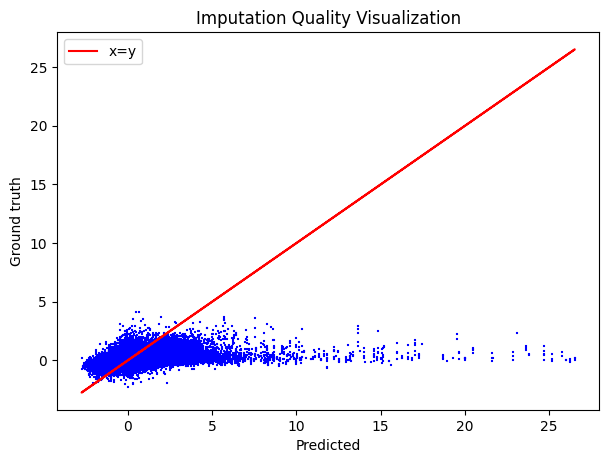

In [146]:
import torch
import matplotlib.pyplot as plt

x_data = ground_truth
y_data = predicted
plt.scatter(x_data, y_data, color = 'blue', marker = '+', s=1)
plt.plot(x_data, x_data, color = 'red', label = 'x=y')
plt.title('Imputation Quality Visualization')
plt.xlabel('Predicted')
plt.ylabel('Ground truth')
plt.legend()
plt.show()

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Error'),
 Text(0.5, 1.0, 'Imputation Error Distribution')]

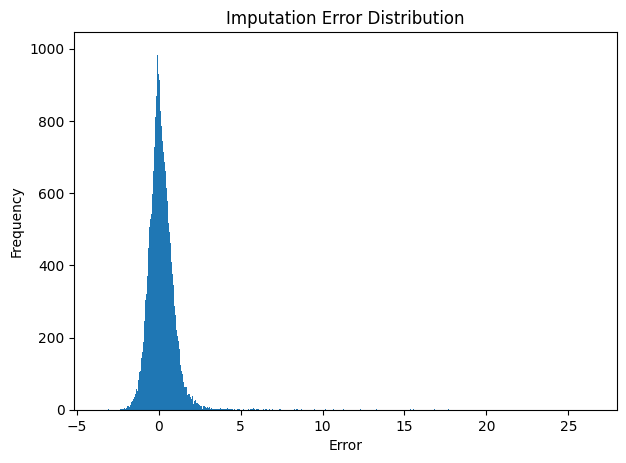

In [147]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
error = [x - y for x, y in zip(ground_truth, predicted)]
plt.hist(error, bins=10000)
plt.gca().set(title='Imputation Error Distribution', xlabel = "Error", ylabel='Frequency')